In [ ]:
import numpy as np
import os
import torch
from sklearn.datasets import fetch_lfw_people
import torchvision.models as models
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split


Fetching Dataset

In [ ]:
# Fetch LFW dataset with minimum faces per person = 40
lfw_people = fetch_lfw_people(min_faces_per_person=40, resize=0.4)
# Extracting data and target labels
X = lfw_people.data
y = lfw_people.target
target_names = lfw_people.target_names
# df = np.genfromtxt('./lfw_people.csv',delimiter=',')
# X = df[:, :-1]
# y = df[:, -1]
n_samples, n_features = X.shape
n_classes = len(np.unique(y))

# Print dataset statistics
print("Number of samples: %d" % n_samples)
print("Number of features: %d" % n_features)
print("Number of classes: %d" % n_classes)

Number of samples: 1777
Number of features: 1850
Number of classes: 17


Restructuring Image Pixel Values

In [ ]:
img = X[0].reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
print(img.shape)

(50, 37)


[[179 182 190 ... 164 159 158]
 [181 185 186 ... 160 159 156]
 [178 183 180 ... 159 155 152]
 ...
 [ 18  23  53 ...  92  74  27]
 [ 24  18  35 ...  90  53  16]
 [ 27  19  21 ...  83  34  12]]
Gloria Macapagal Arroyo


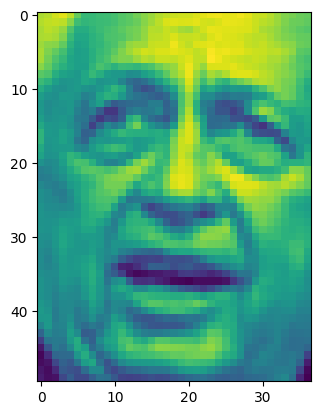

In [ ]:
#Restructuring pixel values to have value between 0 to 255
img = (img * 255).astype(np.uint8)
print(img)
plt.imshow(img)
print(target_names[5])

Model Building

In [ ]:
resnet = models.resnet50(pretrained=True)
resnet = nn.Sequential(*list(resnet.children())[:-1])
resnet.eval()

C:\Users\S.M.Varshit\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\S.M.Varshit\AppData\Roaming\Python\Python311\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


Feature Extraction Function

In [ ]:
def extract_features(image_arrays, model):
    # Load and preprocess the images
    preprocessed_images = []
    for image_array in image_arrays:
        # print(image_array.shape)
        img = image_array.reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
        img = (img * 255).astype(np.uint8)
        image = Image.fromarray(img).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale images
        ])
        image = preprocess(image)
        preprocessed_images.append(image)

    # Stack the preprocessed images to create a batch tensor
    batch_tensor = torch.stack(preprocessed_images)

    # Extract features
    with torch.no_grad():
        features = model(batch_tensor)

    return features

# img = X[0].reshape((lfw_people.images.shape[1],lfw_people.images.shape[2]))
# img = (img * 255).astype(np.uint8)

In [ ]:
print(y.shape)

(1777,)


Batch division

In [ ]:
batch_size = 28

X_train_batches = []
y_train_batches = []

for i in range(int(X.shape[0]/batch_size)):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    batch1 = X[start_idx:end_idx]
    batch2 = y[start_idx:end_idx]
    X_train_batches.append(batch1)
    y_train_batches.append(batch2)

if len(X) % batch_size != 0:
    last_batch = X[batch_size * batch_size:]
    X_train_batches.append(last_batch)

X_train_batches.pop()
X_batches = np.array(X_train_batches)
y_batches = np.array(y_train_batches)

In [ ]:
y_batches.shape

(63, 28)

In [ ]:
y2 = y_batches.reshape(-1,1)
y2 = y2.squeeze(1)
y2.shape

(1764,)

In [ ]:
print(X_batches.shape)
print(X_batches[0].shape)

(63, 28, 1850)
(28, 1850)


Feature Extraction

In [ ]:
output = []
for i in range(X_batches.shape[0]):
  print('Iteration: ', i, '\n')
  features = extract_features(X_batches[i], resnet)
  output.append(features)

Iteration:  0 

Iteration:  1 

Iteration:  2 

Iteration:  3 

Iteration:  4 

Iteration:  5 

Iteration:  6 

Iteration:  7 

Iteration:  8 

Iteration:  9 

Iteration:  10 

Iteration:  11 

Iteration:  12 

Iteration:  13 

Iteration:  14 

Iteration:  15 

Iteration:  16 

Iteration:  17 

Iteration:  18 

Iteration:  19 

Iteration:  20 

Iteration:  21 

Iteration:  22 

Iteration:  23 

Iteration:  24 

Iteration:  25 

Iteration:  26 

Iteration:  27 

Iteration:  28 

Iteration:  29 

Iteration:  30 

Iteration:  31 

Iteration:  32 

Iteration:  33 

Iteration:  34 

Iteration:  35 

Iteration:  36 

Iteration:  37 

Iteration:  38 

Iteration:  39 

Iteration:  40 

Iteration:  41 

Iteration:  42 

Iteration:  43 

Iteration:  44 

Iteration:  45 

Iteration:  46 

Iteration:  47 

Iteration:  48 

Iteration:  49 

Iteration:  50 

Iteration:  51 

Iteration:  52 

Iteration:  53 

Iteration:  54 

Iteration:  55 

Iteration:  56 

Iteration:  57 

Iteration:  58 

Iterati

In [ ]:
output = np.array(output) #Conversion of list to array
output = output.squeeze(3).squeeze(3) #Squeezing last two dimensions to make it a 3-D array
output = output.reshape(-1,2048) #Reshaping into a 2-D array
torch.save(output, 'extracted_features.pt') #Saving the extracted features in a pt file so that it can be used later